In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import numpy as np

from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.layers import Input
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM, Embedding

2023-04-18 23:51:55.890000: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
cards = pd.read_json("data/cards.json")
cards

,name,rules_text,colors,color_identity,flavour_text,type_line,power,toughness,set
0,Static Orb,"As long as CARDNAME is untapped, players can't...","[0, 0, 0, 0, 0, 1]","[0, 0, 0, 0, 0, 1]",NaN,Artifact,None,None,7ed
1,Sensory Deprivation,Enchant creature\nEnchanted creature gets <-3/...,"[0, 1, 0, 0, 0, 0]","[0, 1, 0, 0, 0, 0]",NaN,Enchantment — Aura,None,None,m14
2,Road of Return,Choose one —\n• Return target permanent card f...,"[0, 0, 0, 0, 1, 0]","[0, 0, 0, 0, 1, 0]",NaN,Sorcery,None,None,c19
3,Storm Crow,Flying (This creature can't be blocked except ...,"[0, 1, 0, 0, 0, 0]","[0, 1, 0, 0, 0, 0]",NaN,Creature — Bird,1,2,9ed
4,Walking Sponge,tap: Target creature loses your choice of fly...,"[0, 1, 0, 0, 0, 0]","[0, 1, 0, 0, 0, 0]",NaN,Creature — Sponge,1,1,ulg
...,...,...,...,...,...,...,...,...,...
25132,Devoted Hero,,"[1, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0]",NaN,Creature — Elf Soldier,1,2,s99
25133,Without Weakness,Target creature you control gains indestructib...,"[0, 0, 1, 0, 0, 0]","[0, 0, 1, 0, 0, 0]",NaN,Instant,None,None,hou
25134,Firesong and Sunspeaker,Red instant and sorcery spells you control hav...,"[1, 0, 0, 1, 0, 0]","[1, 0, 0, 1, 0, 0]",NaN,Legendary Creature — Minotaur Cleric,4,6,2x2
25135,"Samut, the Tested",+1: Up to one target creature gains double str...,"[0, 0, 0, 1, 1, 0]","[0, 0, 0, 1, 1, 0]",NaN,Legendary Planeswalker — Samut,None,None,hou


In [3]:
import spacy

en = spacy.load('en_core_web_sm')
stopwords = en.Defaults.stop_words

def text_preprocess(input_text):
    # remove all stop words
    input_text = ' '.join([word for word in input_text.split() if word not in stopwords])

    input_text = ''.join([char for char in input_text if char.isalnum() or char == '/' or char == ' '])

    return input_text

X = []
Y = []

# input_text = type_line + rules_text (if not None) + power / toughness (if not None)
for index, card in cards.iterrows():

    input_text = card['type_line']
    if card['rules_text'] is not None:
        input_text += '\n' + card['rules_text']
    if card['power'] is not None:
        input_text += '\n' + card['power'] + '/' + card['toughness']

    input_text = text_preprocess(input_text)
    
    X.append(input_text)
    Y.append(card["color_identity"])

2023-04-18 23:51:59.182997: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-18 23:51:59.184497: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-18 23:51:59.184794: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [4]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.10)

In [5]:
nr_of_targets= 5

# Remove colorless from array and convert from int to float32
y_train = [np.asarray(y)[0:nr_of_targets].astype('float32').ravel() for y in y_train] 
y_test = [np.asarray(y)[0:nr_of_targets].astype('float32').ravel() for y in y_test]

# Create tensors for tensorflow
y_train = tf.convert_to_tensor(y_train)
y_test = tf.convert_to_tensor(y_test)

2023-04-18 23:52:02.686637: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-18 23:52:02.686932: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-18 23:52:02.687131: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-18 23:52:04.182567: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-18 23:52:04.182821: I tensorflow/compile

In [6]:
# Tokenize text
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(x_train)

x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

In [7]:
vocab_size = len(tokenizer.word_index) + 2
maxlen = 50

# Pad vectors with short text and shorten vectors with long text
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

In [8]:
from numpy import array
from numpy import asarray
from numpy import zeros

# https://keras.io/examples/nlp/pretrained_word_embeddings/
# using pretrained word embeddings from https://nlp.stanford.edu/projects/glove/
embeddings_index = {}
with open('data/glove.6B.100d.txt', encoding="utf8") as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Found 400000 word vectors.
Converted 2421 words (583 misses)


In [9]:
# Create model
deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(deep_inputs)
LSTM_Layer_1 = LSTM(128)(embedding_layer)
dense_layer_1 = Dense(nr_of_targets, activation='sigmoid')(LSTM_Layer_1)
model = Model(inputs=deep_inputs, outputs=dense_layer_1)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

2023-04-18 23:52:20.746382: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-18 23:52:20.748653: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-18 23:52:20.750611: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [10]:
# Fit our model
# Takes ~1 minute
history = model.fit(x_train, y_train, batch_size=128, epochs=15, verbose=1, validation_split=0.1)

Epoch 1/15


2023-04-18 23:52:21.082811: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-18 23:52:21.084804: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-18 23:52:21.086237: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

  5/160 [..............................] - ETA: 2s - loss: 0.6002 - acc: 0.2406  

2023-04-18 23:52:23.032983: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


158/160 [============================>.] - ETA: 0s - loss: 0.4730 - acc: 0.3757

2023-04-18 23:52:26.022882: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-18 23:52:26.024904: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-18 23:52:26.027288: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

160/160 [==============================] - 5s 20ms/step - loss: 0.4726 - acc: 0.3763 - val_loss: 0.4293 - val_acc: 0.4419
Epoch 2/15
160/160 [==============================] - 3s 19ms/step - loss: 0.4029 - acc: 0.4972 - val_loss: 0.3959 - val_acc: 0.5152
Epoch 3/15
160/160 [==============================] - 3s 18ms/step - loss: 0.3662 - acc: 0.5488 - val_loss: 0.3630 - val_acc: 0.5727
Epoch 4/15
160/160 [==============================] - 3s 19ms/step - loss: 0.3444 - acc: 0.5772 - val_loss: 0.3549 - val_acc: 0.6014
Epoch 5/15
160/160 [==============================] - 3s 17ms/step - loss: 0.3267 - acc: 0.6024 - val_loss: 0.3420 - val_acc: 0.5908
Epoch 6/15
160/160 [==============================] - 3s 16ms/step - loss: 0.3123 - acc: 0.6182 - val_loss: 0.3328 - val_acc: 0.6151
Epoch 7/15
160/160 [==============================] - 2s 15ms/step - loss: 0.2989 - acc: 0.6312 - val_loss: 0.3309 - val_acc: 0.6120
Epoch 8/15
160/160 [==============================] - 3s 16ms/step - loss: 0.292

In [11]:
# Model scores
score = model.evaluate(x_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

79/79 [==============================] - 1s 10ms/step - loss: 0.3388 - acc: 0.6094
Test Score: 0.3387974500656128
Test Accuracy: 0.6093874573707581


In [12]:
# Get predictions for our test set
predictions = model.predict(x_test)

20/79 [======>.......................] - ETA: 0s

2023-04-18 23:53:04.848771: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-18 23:53:04.850769: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-18 23:53:04.852701: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

79/79 [==============================] - 1s 6ms/step


In [13]:
from sklearn.metrics import classification_report

LABELS = ["w", "u", "b", "r", "g"]

y_pred = predictions
y_true = y_test.numpy()

upper, lower = 1, 0

y_pred = np.where(y_pred > 0.5, upper, lower)

print(classification_report(
  y_true, 
  y_pred, 
  target_names=LABELS, 
  zero_division=0
))

              precision    recall  f1-score   support

           w       0.77      0.57      0.65       560
           u       0.63      0.77      0.69       508
           b       0.88      0.48      0.62       531
           r       0.73      0.58      0.65       533
           g       0.68      0.68      0.68       542

   micro avg       0.72      0.61      0.66      2674
   macro avg       0.74      0.62      0.66      2674
weighted avg       0.74      0.61      0.66      2674
 samples avg       0.60      0.57      0.57      2674



In [14]:
from sklearn.metrics import multilabel_confusion_matrix
confusion_matrix = multilabel_confusion_matrix(y_true, y_pred)
print(confusion_matrix)

[[[1861   93]
  [ 243  317]]

 [[1777  229]
  [ 118  390]]

 [[1948   35]
  [ 275  256]]

 [[1868  113]
  [ 222  311]]

 [[1802  170]
  [ 175  367]]]


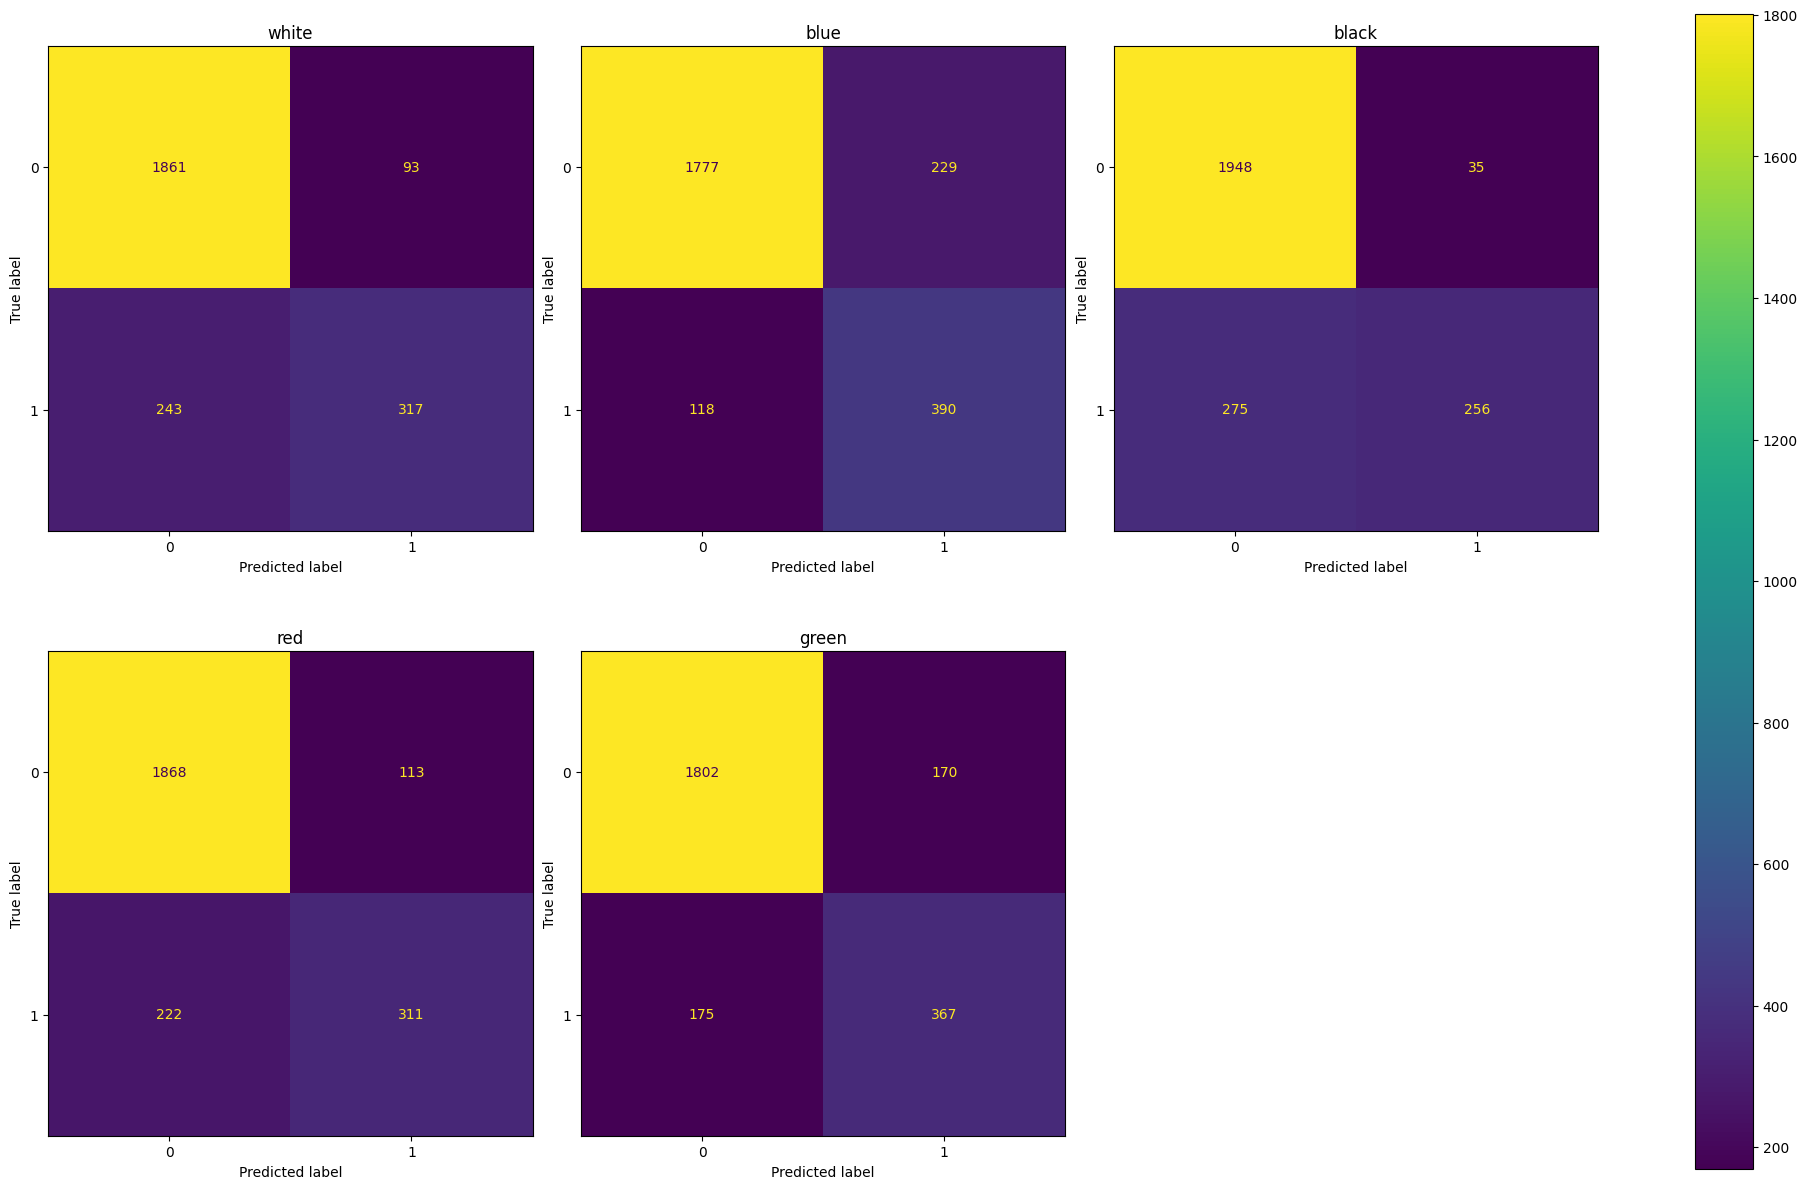

In [15]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

classes=['white', 'blue', 'black', 'red', 'green']

fig = plt.figure(figsize=(25, 15))

axes = []
for i in range(5):
    disp = ConfusionMatrixDisplay(confusion_matrix(y_true[:, i],
                                                   y_pred[:, i]),
                                  display_labels=[0, 1])
    ax= fig.add_subplot(2,3,i + 1)
    axes.append(ax)
    disp.plot(ax=ax, values_format='.4g')
    disp.ax_.set_title(classes[i])    
    disp.im_.colorbar.remove()
    

plt.subplots_adjust(wspace=0.10, hspace=0.1)
fig.colorbar(disp.im_, ax=axes)
plt.show()

In [16]:
# Show some prediction samples
import random

for i in random.sample(range(len(predictions)), 10):
    formatted_y_test = ["%.3f"%item for item in y_test[i]]
    formatted_predictions = ["%.3f"%item for item in predictions[i]]
    
    print("Colors:           [   w   ,    u   ,    b   ,    r   ,    g   ]")
    print("Actual colors:   ", formatted_y_test)
    print("Predicted colors:", formatted_predictions)
    print()

Colors:           [   w   ,    u   ,    b   ,    r   ,    g   ]
Actual colors:    ['0.000', '1.000', '0.000', '0.000', '0.000']
Predicted colors: ['0.017', '0.378', '0.015', '0.028', '0.967']

Colors:           [   w   ,    u   ,    b   ,    r   ,    g   ]
Actual colors:    ['0.000', '0.000', '1.000', '0.000', '0.000']
Predicted colors: ['0.057', '0.367', '0.787', '0.018', '0.042']

Colors:           [   w   ,    u   ,    b   ,    r   ,    g   ]
Actual colors:    ['0.000', '0.000', '0.000', '0.000', '1.000']
Predicted colors: ['0.094', '0.006', '0.000', '0.007', '0.991']

Colors:           [   w   ,    u   ,    b   ,    r   ,    g   ]
Actual colors:    ['0.000', '0.000', '1.000', '0.000', '0.000']
Predicted colors: ['0.002', '0.008', '0.966', '0.057', '0.016']

Colors:           [   w   ,    u   ,    b   ,    r   ,    g   ]
Actual colors:    ['0.000', '0.000', '0.000', '0.000', '0.000']
Predicted colors: ['0.048', '0.056', '0.071', '0.077', '0.030']

Colors:           [   w   ,    u   